# Distance to neighbors w/ different GloVe Dimensionality

In [2]:
import pickle
from os.path import join
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from cupyx.scipy.spatial import distance
import cupy as cp
from pathlib import Path
import sys

# Add the main directory to sys.path to be able to import config
sys.path.append(str(Path.cwd().parent))
from config import ROOT_DIR
from utils.dx import sample_noise_vectors
from utils.tools import compute_distances, argsort_chunked

# PARAMS
number_of_words = 5000
glove_variant = "6B"  # "6B" or "Twitter"
# END PARAMS

distance_metric = "euclidean"
distances_dtype = np.float16  # Precision of the distances
glove_data_folderpath = ROOT_DIR

if glove_variant == "6B":
    glove_dimension_to_filename = {
        50: "glove.6B.50d.pkl",  # 400000 words
        100: "glove.6B.100d.pkl",  # 400000 words
        200: "glove.6B.200d.pkl",  # 400000 words
        300: "glove.6B.300d.pkl",  # 400000 words
    }
elif glove_variant == "Twitter":
    glove_dimension_to_filename = {
        25: "glove.twitter.27B.25d.pkl",  # 1,193,513 words
        50: "glove.twitter.27B.50d.pkl",  # 1,193,513 words
        100: "glove.twitter.27B.100d.pkl",  # 1,193,513 words
        200: "glove.twitter.27B.200d.pkl",  # 1,193,513 words
    }
fit_dtype = np.uint32  # dtype fit to encode the number of words in the vocabulary

# Part 1: Distance to two arbitrary neighbors

In [3]:
# Statistics will be averaged for this number of words
hidden_sizes = list(glove_dimension_to_filename.keys())
x_rank = 1  # Rank of neighbor x
y_rank = 2  # Rank of neighbor y
z_rank = 101 # Rank of neighbor z

The following cell processes each dimension of the selected *glove_variant* in parallel. For each parallel process:
- Load GloVe for the selected dimension
- Take *number_of_words* words and compute the distances against the entire vocabulary
- For each word, rank their neighbors
- For each word, compute the distance between their *x*-th and *y*-th neighbor

In [ ]:
def process_dimension(hidden_size):
    # Load GloVe vocabulary and store it into suitable structures
    with open(
        join(glove_data_folderpath, glove_dimension_to_filename[hidden_size]), "rb"
    ) as f:
        glove = pickle.load(f)

    vocab_embs = cp.array(list(glove.values()))  # Put on GPU
    vocab_size = vocab_embs.shape[0]
    del glove  # Save RAM

    # Take number_of_words words and compute the distances against the entire vocabulary
    words_ids = np.random.choice(vocab_size, size=number_of_words, replace=False)
    words_embeddings = vocab_embs[words_ids]

    # Step by step distance computation for the selected words
    distances = compute_distances(
        words_embeddings, vocab_embs, distance_metric, dtype=distances_dtype
    )

    # For each word, get a sorted list of their neighbors.
    word_neighbors = argsort_chunked(distances, fit_dtype)

    # For each word, get a sorted list of the distances with the entire vocabulary.
    # Instead of sorting again, benefit from word_neighbors.
    sorted_distances = np.take_along_axis(distances, word_neighbors, axis=-1)

    # Distance to the neighbor x
    distances_to_x = sorted_distances[:, x_rank]

    # Distance to the neighbor y
    distances_to_y = sorted_distances[:, y_rank]

    # Distance to the neighbor z
    distances_to_z = sorted_distances[:, z_rank]

    # Gather the ids of x and y
    x_neighbors = word_neighbors[:, x_rank : x_rank + 1]
    y_neighbors = word_neighbors[:, y_rank : y_rank + 1]
    z_neighbors = word_neighbors[:, z_rank : z_rank + 1]
    x_and_y_neighbors = np.concatenate((x_neighbors, y_neighbors), axis=1)
    x_and_z_neighbors = np.concatenate((x_neighbors, z_neighbors), axis=1)

    # Compute the distance between x and y
    distances_between_x_and_y = np.empty((number_of_words), dtype=distances_dtype)
    distances_between_x_and_z = np.empty((number_of_words), dtype=distances_dtype)
    for i in range(number_of_words):
        # Using cdist because cupyx.scipy.spatial.distance.euclidean has a bug https://github.com/cupy/cupy/issues/8288
        distances_between_x_and_y[i] = distance.cdist(
            vocab_embs[x_and_y_neighbors[i][0] : x_and_y_neighbors[i][0] + 1],
            vocab_embs[x_and_y_neighbors[i][1] : x_and_y_neighbors[i][1] + 1],
            distance_metric,
        ).item()

        distances_between_x_and_z[i] = distance.cdist(
            vocab_embs[x_and_z_neighbors[i][0] : x_and_z_neighbors[i][0] + 1],
            vocab_embs[x_and_z_neighbors[i][1] : x_and_z_neighbors[i][1] + 1],
            distance_metric,
        ).item()

    return (distances_to_x, distances_to_y, distances_to_z, distances_between_x_and_y, distances_between_x_and_z)


with ProcessPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_dimension, hidden_sizes))

distances_to_x = dict(
    zip(hidden_sizes, [results[i][0] for i in range(len(hidden_sizes))])
)
distances_to_y = dict(
    zip(hidden_sizes, [results[i][1] for i in range(len(hidden_sizes))])
)
distances_to_z = dict(
    zip(hidden_sizes, [results[i][2] for i in range(len(hidden_sizes))])
)
distances_between_x_and_y = dict(
    zip(hidden_sizes, [results[i][3] for i in range(len(hidden_sizes))])
)
distances_between_x_and_z = dict(
    zip(hidden_sizes, [results[i][4] for i in range(len(hidden_sizes))])
)

CPU times: user 24.9 ms, sys: 69.7 ms, total: 94.6 ms
Wall time: 2min 46s


In [7]:
for hidden_size in hidden_sizes:
    print(
        f"{glove_variant}-{hidden_size}d Average half distance to neighbor {x_rank} = {distances_to_x[hidden_size].mean()/2:.3f}"
    )
    print(
        f"{glove_variant}-{hidden_size}d Average eq19 for neighbor {x_rank} and {y_rank} = {(((distances_to_y[hidden_size]**2)-(distances_to_x[hidden_size]**2))/(2*distances_between_x_and_y[hidden_size])).mean():.3f}"
    )
    print(
        f"{glove_variant}-{hidden_size}d Average eq19 for neighbor {x_rank} and {z_rank} = {(((distances_to_z[hidden_size]**2)-(distances_to_x[hidden_size]**2))/(2*distances_between_x_and_z[hidden_size])).mean():.3f}"
    )

6B-50d Average half distance to neighbor 1 = 1.383
6B-50d Average eq19 for neighbor 1 and 2 = 0.165
6B-50d Average eq19 for neighbor 1 and 101 = 0.750
6B-100d Average half distance to neighbor 1 = 1.410
6B-100d Average eq19 for neighbor 1 and 2 = 0.146
6B-100d Average eq19 for neighbor 1 and 101 = 0.620
6B-200d Average half distance to neighbor 1 = 2.158
6B-200d Average eq19 for neighbor 1 and 2 = 0.218
6B-200d Average eq19 for neighbor 1 and 101 = 0.826
6B-300d Average half distance to neighbor 1 = 2.902
6B-300d Average eq19 for neighbor 1 and 2 = 0.223
6B-300d Average eq19 for neighbor 1 and 101 = 0.988


# Part 2: Bounds on $\Pr[C_i]$ (For Figure 6)
Let $C_{i}$ be the event that word embedding $\mathbf{x}_i$ is the nearest neighbor of $\mathbf{w}^*$. From equations following the Theorem 10, we have the following bounds:

$\Pr[C_i] \leq 1 - \Pr\left[ Z \leq \frac{\lVert{\mathbf{w} - \mathbf{x}_1}\rVert} {2}\right]$ (Eq 20 in the paper) and $\Pr[C_i] \leq \Pr \left[ Z \leq \frac{\lVert{\mathbf{w} - \mathbf{x}_j}\rVert^2 - \lVert{\mathbf{w} - \mathbf{x}_i}\rVert^2  }{2 \lVert{\mathbf{x}_i - \mathbf{x}_j}\rVert}\right] $ (Eq 21 in the paper)

## Step 1
Get $\Pr\left[ Z \leq \frac{\lVert{\mathbf{w} - \mathbf{x}_1}\rVert} {2}\right]$ for different epsilons and dimensions

In [ ]:
# Statistics will be averaged for this number of words
hidden_sizes = list(glove_dimension_to_filename.keys())
epsilons = [i for i in range(1, 51)]

In [ ]:
def process_dimension(hidden_size):
    # Load GloVe vocabulary and store it into suitable structures
    with open(
        join(glove_data_folderpath, glove_dimension_to_filename[hidden_size]), "rb"
    ) as f:
        glove = pickle.load(f)

    vocab_embs = cp.array(list(glove.values()))  # Put on GPU
    vocab_size = vocab_embs.shape[0]
    del glove  # Save RAM

    # Take number_of_words words and compute the distances against the entire vocabulary
    words_ids = np.random.choice(vocab_size, size=number_of_words, replace=False)
    words_embeddings = vocab_embs[words_ids]

    # Step by step distance computation for the selected words
    distances = compute_distances(
        words_embeddings, vocab_embs, distance_metric, dtype=distances_dtype
    )

    # For each word, get a sorted list of their neighbors.
    word_neighbors = distances.argsort(axis=-1).astype(fit_dtype)

    # For each word, get a sorted list of the distances with the entire vocabulary.
    # Instead of sorting again, benefit from word_neighbors.
    # Doing distances[word_neighbors] here would not work as word_neighbors is a 2D array and would
    # result in numpy advanced indexing
    sorted_distances = np.take_along_axis(distances, word_neighbors, axis=-1)

    # Get the distance with the first neighbor of each word
    distance_with_1st_neighbor = sorted_distances[:, 1]

    proportions = {}
    for epsilon in epsilons:
        # Noise the words
        noises = sample_noise_vectors(
            dimension=hidden_size, shape1=1, shape2=number_of_words, epsilon=epsilon
        )[0]

        # z = rk by definition
        # r is the norm of the noise
        r = np.linalg.norm(noises, ord=None, axis=-1)
        # k is the cosine angle between the noise and the word w.
        # This is computed here as one minus the cosine distance between said vectors.
        k = 1 - np.array(
            [
                distance.cdist([noises[i]], [words_embeddings[i]], "cosine")
                .astype(distances_dtype)
                .item()
                for i in range(number_of_words)
            ]
        )

        # Formula of Equation 18 in the paper
        formula = (r * k) <= 1 / 2 * distance_with_1st_neighbor
        proportions[epsilon] = formula.mean()

    return proportions


with ProcessPoolExecutor(max_workers=5) as executor:
    resultsPart1 = list(executor.map(process_dimension, hidden_sizes))

CPU times: user 44.7 ms, sys: 85.9 ms, total: 131 ms
Wall time: 15min 9s


Results are stored in *resultsPart1*, which is a list each item holds the result for one vocabulary dimension, in the same order as *hidden_sizes* variable. Each item of *resultsPart1* is a dictionary where the keys are integers representing the value of epsilon. The dictionary associates each epsilon with a float representing the empirical probability $\Pr\left[ Z \leq \frac{\lVert{\mathbf{w} - \mathbf{x}_1}\rVert} {2}\right]$

## Step 2
Get $\Pr \left[ Z \leq \frac{\lVert{\mathbf{w} - \mathbf{x}_j}\rVert^2 - \lVert{\mathbf{w} - \mathbf{x}_i}\rVert^2  }{2 \lVert{\mathbf{x}_i - \mathbf{x}_j}\rVert}\right]$ for
- 1st and 2nd neighbors
- 1st and 101th neighbors

Define parameters

In [10]:
# Statistics will be averaged for this number of words
number_of_words = 5000
hidden_sizes = list(glove_dimension_to_filename.keys())
epsilons = [i for i in range(1, 51)]

# X and Y pairs to test
x_ranks = [1, 1]
y_ranks = [2, 101]
assert len(x_ranks) == len(y_ranks)

Compute the formula in parallel

In [ ]:
def process_dimension(hidden_size):
    # Load GloVe vocabulary and store it into suitable structures
    with open(
        join(glove_data_folderpath, glove_dimension_to_filename[hidden_size]), "rb"
    ) as f:
        glove = pickle.load(f)

    vocab_embs = cp.array(list(glove.values()))  # Put on GPU
    vocab_size = vocab_embs.shape[0]
    del glove  # Save RAM

    # Take number_of_words words and compute the distances against the entire vocabulary
    words_ids = np.random.choice(vocab_size, size=number_of_words, replace=False)
    words_embeddings = vocab_embs[words_ids]

    # Step by step distance computation for the selected words
    distances = compute_distances(
        words_embeddings, vocab_embs, distance_metric, dtype=distances_dtype
    )

    # For each word, get a sorted list of their neighbors.
    word_neighbors = distances.argsort(axis=-1).astype(fit_dtype)

    # For each word, get a sorted list of the distances with the entire vocabulary.
    # Instead of sorting again, benefit from word_neighbors.
    sorted_distances = np.take_along_axis(distances, word_neighbors, axis=-1)

    results = []
    # For all x and y pairs defined above
    for i in range(len(x_ranks)):
        x_rank = x_ranks[i]
        y_rank = y_ranks[i]
        # Distance to the neighbor x
        distances_to_x = sorted_distances[:, x_rank]

        # Distance to the neighbor y
        distances_to_y = sorted_distances[:, y_rank]

        # Compute the distance between the word and x, between the word and y, and between x and y
        x_neighbors = word_neighbors[:, x_rank : x_rank + 1]
        y_neighbors = word_neighbors[:, y_rank : y_rank + 1]
        x_and_y_neighbors = np.concatenate((x_neighbors, y_neighbors), axis=1)

        distances_between_x_and_y = np.array(
            [
                distance.cdist(
                    vocab_embs[x_and_y_neighbors[i][0] : x_and_y_neighbors[i][0] + 1],
                    vocab_embs[x_and_y_neighbors[i][1] : x_and_y_neighbors[i][1] + 1],
                    distance_metric,
                )
                .astype(distances_dtype)
                .item()
                for i in range(number_of_words)
            ],
            dtype=distances_dtype,
        )

        # Compute the formula defined above
        proportions = {}
        for epsilon in epsilons:
            # Noise the words
            noises = sample_noise_vectors(
                dimension=hidden_size, shape1=1, shape2=number_of_words, epsilon=epsilon
            )[0]

            # z = rk by definition
            # r is the norm of the noise
            r = np.linalg.norm(noises, ord=None, axis=-1)
            # k is the cosine angle between the noise and the word w.
            # This is computed here as one minus the cosine distance between said vectors.
            k = 1 - np.array(
                [
                    distance.cdist([noises[i]], [words_embeddings[i]], "cosine")
                    .astype(distances_dtype)
                    .item()
                    for i in range(number_of_words)
                ]
            )

            # Formula of Equation 19 in the paper
            formula = (r * k) <= ((distances_to_y**2) - (distances_to_x**2)) / (
                2 * distances_between_x_and_y
            )
            proportions[epsilon] = formula.mean()
        results.append(proportions)
    return {
        "results": results,
        "x_ranks": x_ranks,
        "y_ranks": y_ranks,
        "epsilons": epsilons,
    }


with ProcessPoolExecutor(max_workers=5) as executor:
    resultsPart2 = list(executor.map(process_dimension, hidden_sizes))

CPU times: user 47.6 ms, sys: 62.8 ms, total: 110 ms
Wall time: 15min 26s


Results are stored in *resultsPart2*, which is a list each item holds the result for one vocabulary dimension, in the same order as *hidden_sizes* variable. Each item of *resultsPart2* is a dictionary where the keys are integers representing the value of epsilon. The dictionary associates each epsilon with a float representing the empirical probability $\Pr \left[ Z \leq \frac{\lVert{\mathbf{w} - \mathbf{x}_j}\rVert^2 - \lVert{\mathbf{w} - \mathbf{x}_i}\rVert^2  }{2 \lVert{\mathbf{x}_i - \mathbf{x}_j}\rVert}\right]$

Plot given the values found above

In [8]:
import numpy as np

# PARAMETERS
epsilons = [i for i in range(1, 51)]
vocab = "glove-twitter"
runs = 10000


def getData(vocab):
    if vocab == "glove-twitter":
        dims = ["25", "50", "100", "200"]
        vals_w = {
            "25": 1.078,
            "50" : 1.571,
            "100" : 2.166,
            "200" : 2.708
        }
        vals_x1_x2 = {
            "25": 0.132,
            "50" : 0.169,
            "100" : 0.197,
            "200" : 0.220
        }
        vals_x1_x101 = {
            "25": 0.692,
            "50" : 0.747,
            "100" : 0.764,
            "200" : 0.683
        }
        
    elif vocab == "glove-wiki":
        dims = ["50", "100", "200", "300"]
        vals_w = {
            "50": 1.369,
            "100" : 1.403,
            "200" : 2.15,
            "300" : 2.896 
        }
        vals_x1_x2 = {
            "50": 0.172,
            "100" : 0.152,
            "200" : 0.243,
            "300" : 0.282
        }
        vals_x1_x101 = {
            "50": 0.757,
            "100" : 0.616,
            "200" : 0.823,
            "300" : 0.999
        }
    return dims, vals_w, vals_x1_x2, vals_x1_x101

def getNoise(dim, scale):
    x = np.random.normal(0, 1, dim)
    magx = np.linalg.norm(x)
    x = [i/magx for i in x] # normalize
    l = np.random.gamma(dim, scale)
    x = [l*i for i in x]
    return np.array(x)

def getNoiseDotProd(dim, eta):
    x = [0 for i in range(dim)]
    x[1] = 1 # doesn't matter what vector you take the dot product with
    return np.dot(x, eta)


dims, vals_w, vals_x1_x2, vals_x1_x101 = getData(vocab)

probs_w = {dim: [] for dim in dims}
probs_x1_x2 = {dim: [] for dim in dims}
probs_x1_x101 = {dim: [] for dim in dims}

for eps in epsilons:
    scale = 1/eps
    counts_w = {dim: 0 for dim in dims}
    counts_x1_x2 = {dim: 0 for dim in dims}
    counts_x1_x101 = {dim: 0 for dim in dims}
    for r in range(runs):       
        for dim in dims:
            eta = getNoise(int(dim), scale)
            z = getNoiseDotProd(int(dim), eta)
            if z <= vals_w[dim]:
                counts_w[dim] += 1
            if z <= vals_x1_x2[dim]:
                counts_x1_x2[dim] += 1
            if z <= vals_x1_x101[dim]:
                counts_x1_x101[dim] += 1
    for dim in dims:
        probs_w[dim].append(counts_w[dim]/runs)
        probs_x1_x2[dim].append(counts_x1_x2[dim]/runs)
        probs_x1_x101[dim].append(counts_x1_x101[dim]/runs)

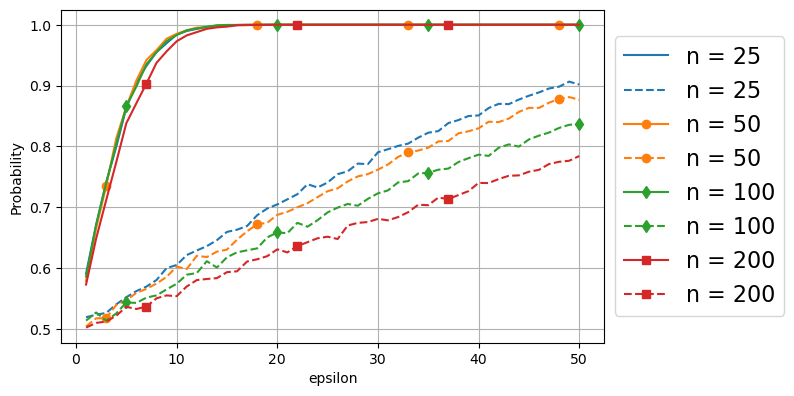

In [9]:
import matplotlib.colors as mc
import matplotlib.pyplot as plt
golden_ratio = (1 + 5 ** 0.5) / 2

fig, ax = plt.subplots(figsize=(7, 7/golden_ratio))
#color = iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
color = iter(mc.TABLEAU_COLORS)

markers = iter(["","o","d", "s"])
marker_starts = iter([0, 2, 4, 6])

for dim in dims:
    c = next(color)
    marker = next(markers)
    marker_start = next(marker_starts)
    ax.plot(epsilons, probs_w[dim], c=c, label = "n = " + dim, linewidth=1.5, marker=marker, markevery=(marker_start, 15))
    ax.plot(epsilons, probs_x1_x2[dim], linestyle = "--", c=c, label = "n = " + dim, linewidth=1.5, marker=marker, markevery=(marker_start, 15))
    #plt.plot(epsilons, probs_x1_x101[dim], linestyle = "dashdot", c=c, label = "$n$ = " + dim)

plt.rcParams.update({'font.size': 16})
ax.set_xlabel("epsilon")
ax.set_ylabel("Probability")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
fig.show()